In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import Union, List, Optional
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
class PTBXL_Dataset(Dataset):
    """
    A PyTorch Dataset for ECG samples grouped by subject (PTB-XL).

    Args:
        data_path (str): Path to the .pt file with data grouped by subject.
        subject_ids (Union[float, List[float], None]): Subject(s) to include. If None, uses all subjects.
        split (str): 'train', 'test', or None — whether to return a subset.
        test_ratio (float): Proportion to reserve for test split (if split is specified).
        random_seed (int): Random seed for reproducibility.
    """
    def __init__(
        self,
        data_path: str,
        subject_ids: Optional[Union[float, List[float]]] = None,
        split: Optional[str] = None,
        test_ratio: float = 0.2,
        val_ratio: float = 0.2,
        random_seed: int = 42
    ):
        assert split in [None, 'train', 'val', 'test'], "split must be None, 'train', 'val', or 'test'"

        raw_data = torch.load(data_path)
        all_subject_data = raw_data['data_by_subject']
        self.label_encoder = raw_data['label_encoder']
        # label index: [0:'AFIB' 1:'NORM' 2:'PAC' 3:'PVC' 4:'SBRAD' 5:'STACH']

        # Normalize subject_ids to list
        if subject_ids is None:
            selected_subjects = list(all_subject_data.keys())
        elif isinstance(subject_ids, float):
            selected_subjects = [subject_ids]
        else:
            selected_subjects = subject_ids

        # Collect all (x, y) pairs per subject
        all_samples = []

        for sid in selected_subjects:
            subject_data = all_subject_data[sid]
            x_list = subject_data['x']
            y_list = subject_data['y']
            samples = list(zip(x_list, y_list))
            all_samples.extend(samples)

        # Split based on sample count
        if split is not None:
            stratify_labels = [int(y) for _, y in all_samples]

            # First split into temp (train+val) and test
            temp_idx, test_idx = train_test_split(
                range(len(all_samples)),
                test_size=test_ratio,
                random_state=random_seed,
                stratify=stratify_labels
            )

            temp_samples = [all_samples[i] for i in temp_idx]
            temp_labels = [int(y) for _, y in temp_samples]

            # Now split temp into train and val
            train_idx, val_idx = train_test_split(
                range(len(temp_samples)),
                test_size=val_ratio,
                random_state=random_seed,
                stratify=temp_labels
            )

            if split == 'train':
                indices = [temp_idx[i] for i in train_idx]
            elif split == 'val':
                indices = [temp_idx[i] for i in val_idx]
            elif split == 'test':
                indices = test_idx

            self.samples = [all_samples[i] for i in indices]
        else:
            self.samples = all_samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return x.unsqueeze(0), y  # Add channel dimension: (1, 2500)


In [3]:
class Siamese_Dataset(Dataset):
    def __init__(self, base_dataset):
        self.base = base_dataset
        # split into normal/abnormal pools
        self.normal = [i for i, (_, y) in enumerate(self.base) if y.item() == 0]
        self.abnormal = [i for i, (_, y) in enumerate(self.base) if y.item() != 0]

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        x1, y1 = self.base[idx]
        y1_bin = int(y1 == 0)  # 0 if normal

        # Sample x2
        if torch.rand(1).item() < 0.5:
            # same class
            pool = self.normal if y1_bin == 1 else self.abnormal
            idx2 = random.choice(pool)
            label = 1
        else:
            # different class
            pool = self.abnormal if y1_bin == 1 else self.normal
            idx2 = random.choice(pool)
            label = 0

        x2, y2 = self.base[idx2]
        return (x1, x2), torch.tensor(label, dtype=torch.float32)


In [4]:
class Embedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 8, 16, stride=2, padding=7),
            nn.ReLU(),
            # nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=8, stride=4),

            nn.Conv1d(8, 12, 12, padding=5, stride=2),
            nn.ReLU(),
            # nn.BatchNorm1d(16),
            nn.MaxPool1d(4, stride=2),

            nn.Conv1d(12, 32, 9, stride=1, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),

            nn.Conv1d(32, 64, 7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4, stride=2),

            nn.Conv1d(64, 64, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),

            nn.Conv1d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),

            nn.Conv1d(64, 72, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
        )
        self.output = nn.Linear(in_features=144, out_features=64)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.output(x)

class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = Embedding()
        self.classifier = nn.Sequential(
            nn.Linear(64 * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        f1 = self.embedding(x1)
        f2 = self.embedding(x2)
        distance = torch.nn.functional.pairwise_distance(f1, f2)
        combined = torch.cat([f1, f2], dim=1)
        prob = self.classifier(combined).squeeze()
        return distance, prob


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, dist, label):
        loss = label * dist.pow(2) + (1 - label) * (self.margin - dist).clamp(min=0).pow(2)
        return loss.mean()

In [ ]:
# Step 1: Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Step 2: Prepare dataset and dataloader
batch_size = 50
# Load dataset
train_data = PTBXL_Dataset("./datasets/ptbxl_all_data.pt", split='train')
val_data = PTBXL_Dataset("./datasets/ptbxl_all_data.pt", split='val')
test_data = PTBXL_Dataset("./datasets/ptbxl_all_data.pt", split='test')

train_dataset = Siamese_Dataset(train_data)
val_dataset = Siamese_Dataset(val_data)
test_dataset = Siamese_Dataset(test_data)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    

Using device: cpu


In [12]:
print(train_data.label_encoder.classes_)

['NORM' 'AFIB' 'PAC' 'PVC' 'SBRAD' 'STACH']


In [ ]:
model = SiameseNet().to(device)
contrastive_loss_fn = ContrastiveLoss(margin=1.0)
bce_loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

lambda_contrastive = 1.0
lambda_bce = 1.0

best_val_acc = 0.0
best_model_path = "./models/NormalClassifier.pth"

num_epochs = 100
for epoch in range(num_epochs):
    # === TRAIN ===
    model.train()
    train_losses, train_preds, train_labels = [], [], []

    for (x1, x2), label in train_loader:
        x1, x2 = x1.to(device), x2.to(device)
        label = label.to(device)

        dist, prob = model(x1, x2)
        loss_contrastive = contrastive_loss_fn(dist, label)
        loss_bce = bce_loss_fn(prob, label.float())
        loss = lambda_contrastive * loss_contrastive + lambda_bce * loss_bce

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_preds.extend((prob > 0.5).int().cpu().numpy())
        train_labels.extend(label.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)

    # === VALIDATION ===
    model.eval()
    val_losses, val_preds, val_labels = [], [], []
    with torch.no_grad():
        for (x1, x2), label in val_loader:
            x1, x2 = x1.to(device), x2.to(device)
            label = label.to(device)

            dist, prob = model(x1, x2)
            loss_contrastive = contrastive_loss_fn(dist, label)
            loss_bce = bce_loss_fn(prob, label.float())
            loss = lambda_contrastive * loss_contrastive + lambda_bce * loss_bce

            val_losses.append(loss.item())
            val_preds.extend((prob > 0.5).int().cpu().numpy())
            val_labels.extend(label.cpu().numpy())
    
    val_acc = accuracy_score(val_labels, val_preds)
    # === Report ===
    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {sum(train_losses)/len(train_losses):.4f} | "
          f"Train Acc: {train_acc:.4f} | "
          f"Val Loss: {sum(val_losses)/len(val_losses):.4f} | "
          f"Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model updated")

print(f"Best model Validation Accuracy: {best_val_acc:.4f})")

Epoch 01 | Train Loss: 0.8362 | Train Acc: 0.6331 | Val Loss: 0.7032 | Val Acc: 0.7072
Best model updated
Epoch 02 | Train Loss: 0.5118 | Train Acc: 0.8437 | Val Loss: 0.4302 | Val Acc: 0.8758
Best model updated
Epoch 03 | Train Loss: 0.4070 | Train Acc: 0.8734 | Val Loss: 0.3208 | Val Acc: 0.9042
Best model updated
Epoch 04 | Train Loss: 0.3484 | Train Acc: 0.8908 | Val Loss: 0.3151 | Val Acc: 0.9107
Best model updated
Epoch 05 | Train Loss: 0.3290 | Train Acc: 0.9026 | Val Loss: 0.3181 | Val Acc: 0.9112
Best model updated
Epoch 06 | Train Loss: 0.2923 | Train Acc: 0.9118 | Val Loss: 0.3364 | Val Acc: 0.8988
Epoch 07 | Train Loss: 0.2785 | Train Acc: 0.9146 | Val Loss: 0.4088 | Val Acc: 0.8873
Epoch 08 | Train Loss: 0.2592 | Train Acc: 0.9247 | Val Loss: 0.3740 | Val Acc: 0.8968
Epoch 09 | Train Loss: 0.2473 | Train Acc: 0.9270 | Val Loss: 0.3881 | Val Acc: 0.8933
Epoch 10 | Train Loss: 0.2162 | Train Acc: 0.9393 | Val Loss: 0.3582 | Val Acc: 0.9072
Epoch 11 | Train Loss: 0.1925 | Tra

In [ ]:
model = SiameseNet().to(device)
model.load_state_dict(torch.load("./models/NormalClassifier.pth"))
model.eval()

test_preds, test_labels = [], []

with torch.no_grad():
    for (x1, x2), label in test_loader:
        x1, x2 = x1.to(device), x2.to(device)
        label = label.to(device)

        _, prob = model(x1, x2)
        preds = (prob > 0.5).int()

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(label.cpu().numpy())

print(classification_report(test_labels, test_preds, target_names=['SAME', 'DIFF']))
# precision(TP/TP+FP), recall(TP/TP+FN)

              precision    recall  f1-score   support

        SAME       0.90      0.89      0.90      1255
        DIFF       0.89      0.90      0.90      1252

    accuracy                           0.90      2507
   macro avg       0.90      0.90      0.90      2507
weighted avg       0.90      0.90      0.90      2507



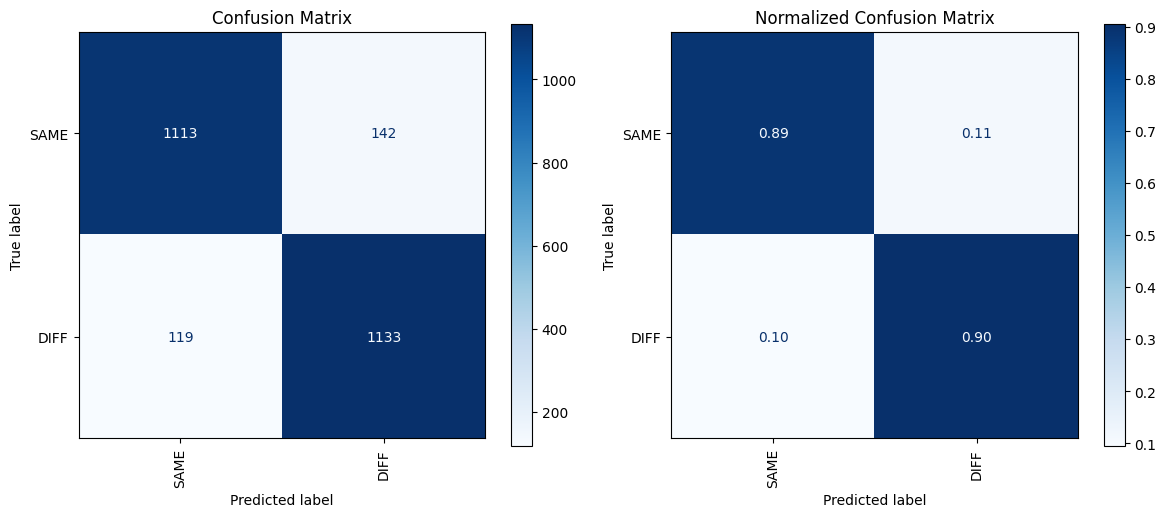

In [7]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
class_names = ['SAME', 'DIFF']

# Normalize
cm_normalized = np.divide(
    cm.astype('float'),
    cm.sum(axis=1)[:, np.newaxis],
    out=np.zeros_like(cm, dtype=float),
    where=cm.sum(axis=1)[:, np.newaxis] != 0
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Raw confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp1.plot(ax=ax1, cmap='Blues', xticks_rotation='vertical', colorbar=True)
ax1.set_title("Confusion Matrix")

# Normalized confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp2.plot(ax=ax2, cmap='Blues', xticks_rotation='vertical', values_format=".2f", colorbar=True)
ax2.set_title("Normalized Confusion Matrix")

plt.tight_layout()
plt.show()